Consiga un data set de cualquier tipo, estudie sus características (features) y su rótulo. Diseñe una red neuronal y haga ejemplos con base en los pesos aprendidos.

Usando el dataset encontrado en Tensorflow cifar10, que contiene imágenes de 10 clases diferentes (aviones, automóviles, pájaros, gatos, ciervos, perros, ranas, caballos, barcos y camiones), se desarrollo una red neuronal empleando los pesos aprendidos en clase.

In [19]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import cv2
import requests
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Cargar y preprocesar CIFAR-10 con tf.data.Dataset
datos, metadatos = tfds.load("cifar10", as_supervised=True, with_info=True)

# Normalización de imágenes con matriz de pesos aleatorios
def preprocesar(imagen, etiqueta):
    imagen = tf.image.convert_image_dtype(imagen, tf.float32)  # Convertir a float sin necesidad de .numpy()
    peso_matriz = tf.random.uniform((32, 32, 3), 0.5, 1.5)  # Crear matriz de pesos en TensorFlow
    imagen = imagen * peso_matriz
    imagen = tf.clip_by_value(imagen, 0, 1)  # Mantener valores en el rango [0,1]
    return imagen, etiqueta

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

def aplicar_augmentacion(imagen, etiqueta):
    imagen = data_augmentation(imagen)
    return imagen, etiqueta

# Preparar dataset
BUFFER_SIZE = 10000
BATCH_SIZE = 64

datos_entrenamiento = (datos["train"]
    .shuffle(BUFFER_SIZE)
    .map(preprocesar)
    .map(aplicar_augmentacion)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE))

datos_validacion = (datos["test"]
    .map(preprocesar)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE))

# Definir modelo CNN
modelo = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

modelo.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Entrenamiento del modelo
historial = modelo.fit(
    datos_entrenamiento,
    validation_data=datos_validacion,
    epochs=50,
    verbose=1
)

# Prueba con imagen del dataset
def predecir_imagen_dataset():
    for imagen, etiqueta in datos["test"].take(1):
        img_array = tf.expand_dims(imagen, axis=0)
        prediccion = modelo.predict(img_array)
        clase_predicha = np.argmax(prediccion)
        plt.imshow(imagen.numpy().astype("uint8"))
        plt.title(f"Clase Predicha: {clase_predicha}")
        plt.axis("off")
        plt.show()

# Prueba con imagen de internet
def predecir_imagen(url):
    predecir_imagen("https://upload.wikimedia.org/wikipedia/commons/9/96/Cat-03.jpg")
    respuesta = requests.get(url, stream=True)
    if respuesta.status_code == 200:
        with open("imagen_prueba.jpg", 'wb') as f:
            f.write(respuesta.content)

    img = image.load_img("imagen_prueba.jpg", target_size=(32, 32))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediccion = modelo.predict(img_array)
    clase_predicha = np.argmax(prediccion)

    print(f"La imagen pertenece a la clase: {clase_predicha}")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# Ejemplo de uso:
# predecir_imagen_dataset()
# predecir_imagen('URL_DE_LA_IMAGEN')

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 60s 74ms/step - accuracy: 0.2863 - loss: 1.9142 - val_accuracy: 0.4511 - val_loss: 1.5101
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - accuracy: 0.4679 - loss: 1.4744 - val_accuracy: 0.4896 - val_loss: 1.4258
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 66ms/step - accuracy: 0.5134 - loss: 1.3572 - val_accuracy: 0.5378 - val_loss: 1.2961
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - accuracy: 0.5420 - loss: 1.2808 - val_accuracy: 0.5349 - val_loss: 1.3094
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 70ms/step - accuracy: 0.5628 - loss: 1.2344 - val_accuracy: 0.5595 - val_loss: 1.2429
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - accuracy: 0.5781 - loss: 1.1914 - val_accuracy: 0.5618 - val_loss: 1.2392
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 84s 69ms/step - accuracy: 0.5839 - loss: 1.1604 - val_accuracy: 0.5608 - val_loss: 1.2504
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.6036 - loss: 1.1346 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


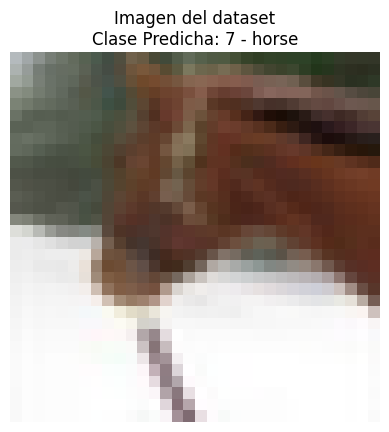

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


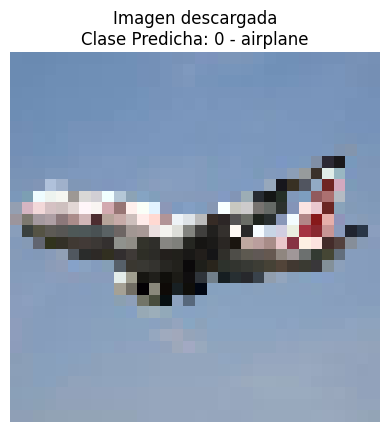

In [51]:
# Obtener función para convertir índices a nombres de clases
int2str = metadatos.features["label"].int2str

def predecir_imagen_dataset():
    """Muestra una imagen del dataset con su predicción."""
    for imagen, etiqueta in datos["test"].take(1):
        img_array = tf.expand_dims(imagen, axis=0)
        prediccion = modelo.predict(img_array)
        clase_predicha = np.argmax(prediccion)
        nombre_clase = int2str(clase_predicha)  # Convertir índice a nombre

        plt.imshow(imagen.numpy().astype("uint8"))
        plt.title(f"Imagen del dataset\nClase Predicha: {clase_predicha} - {nombre_clase}")
        plt.axis("off")
        plt.show()

def predecir_imagen():
    """Descarga y predice una imagen de internet."""
    url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcShBuinWrJIE4zjd-U-Evn2sMDjcvk7xn5uUA&s"
    archivo_imagen = "imagen_prueba.jpg"

    # Descargar imagen
    respuesta = requests.get(url, stream=True)

    if respuesta.status_code == 200:
        with open(archivo_imagen, 'wb') as f:
            f.write(respuesta.content)
    else:
        print("Error al descargar la imagen. Código de estado:", respuesta.status_code)
        return

    # Verificar si la imagen se descargó correctamente
    if not os.path.exists(archivo_imagen):
        print("No se pudo guardar la imagen. Verifica los permisos de escritura.")
        return

    # Cargar imagen
    img = image.load_img(archivo_imagen, target_size=(32, 32))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediccion = modelo.predict(img_array)
    clase_predicha = np.argmax(prediccion)
    nombre_clase = int2str(clase_predicha)  # Convertir índice a nombre

    plt.imshow(img)
    plt.title(f"Imagen descargada\nClase Predicha: {clase_predicha} - {nombre_clase}")
    plt.axis("off")
    plt.show()

# Ejecutar pruebas
predecir_imagen_dataset()
predecir_imagen()